# Quantifying optomotor rising slope

Quantify the slope of the rising/falling edge in experiments of looming with background moving clockwise/counter-clockwise.

# Setup

In [1]:
%matplotlib notebook

In [2]:
import os
from pathdefs import * # Custom import containing definitions of SOURCEPATH and DATAPATH. May override as needed
#os.chdir("C:/Users/fischer/notebooks")
#os.chdir("C:/Users/Phil/documents/notebooks")
os.chdir(SOURCEPATH) # SOURCEPATH defined in "pathdefs"

import Looming_with_background_Analyzer as lwb

import baseClasses as bc

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats

import glob
import helperLibrary
import copy

In [3]:
sample_optomotor = 4. #in frames after max loom
sample_endLoom = 1.33#in frames after max loom #depolarization needs to wear off after looming stim

# load
## load HP/NP contra

In [4]:
# meaning "for saccades to the right" (because looming on the left), therefore ..._Rhyp/_Rnop
saFly_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__flying.neomat'))
saRest_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__resting.neomat'))
saFly_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__flying.neomat'))
saRest_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__resting.neomat'))

In [5]:
# OPTIONAL: load new subsets

saSacc_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__CWTdetection_saccading.neomat'))
# saStrg_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
#                             'Collections_saccade_straight', 'newSorting',
#                             'loomLeft_hyPol__CWTdetection_straight.neomat')) #not needed
saSacc_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__CWTdetection_saccading.neomat'))
# saStrg_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
#                             'Collections_saccade_straight', 'newSorting',
#                             'loomLeft_noPol__CWTdetection_straight.neomat')) #not needed

In [6]:
saFly_Rhyp.clean_flyIDs()
saFly_Rhyp.reallocate_fly_indices()
saRest_Rhyp.clean_flyIDs()
saRest_Rhyp.reallocate_fly_indices()

saFly_Rnop.clean_flyIDs()
saFly_Rnop.reallocate_fly_indices()
saRest_Rnop.clean_flyIDs()
saRest_Rnop.reallocate_fly_indices()

saSacc_Rhyp.clean_flyIDs()
saSacc_Rhyp.reallocate_fly_indices()
saSacc_Rnop.clean_flyIDs()
saSacc_Rnop.reallocate_fly_indices()

## load HP/NP spont

In [7]:
# meaning "for saccades to the left" (because looming on the right), therefore ..._Lhyp/_Lnop
saFly_Lhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                            'Collections_saccade_straight',
                            'saccLeft_hyPol__flying.neomat')) #not needed
saRest_Lhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight',
                            'saccLeft_hyPol__resting.neomat'))
saFly_Lnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight',
                            'saccLeft_noPol__flying.neomat'))
saRest_Lnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight',
                            'saccLeft_noPol__resting.neomat'))

In [8]:
# OPTIONAL: load new subsets

saSacc_Lhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight',
                            'saccLeft_hyPol__CWTdetection_saccading.neomat'))
# saStrg_Lhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
#                             'Collections_saccade_straight',
#                             'saccLeft_hyPol__CWTdetection_straight.neomat')) #not needed
saSacc_Lnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight',
                            'saccLeft_noPol__CWTdetection_saccading.neomat'))
# saStrg_Lnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
#                             'Collections_saccade_straight',
#                             'saccLeft_noPol__CWTdetection_straight.neomat'))

In [9]:
saFly_Lhyp.clean_flyIDs()
saFly_Lhyp.reallocate_fly_indices()
saRest_Lhyp.clean_flyIDs()
saRest_Lhyp.reallocate_fly_indices()

saFly_Lnop.clean_flyIDs()
saFly_Lnop.reallocate_fly_indices()
saRest_Lnop.clean_flyIDs()
saRest_Lnop.reallocate_fly_indices()

saSacc_Lhyp.clean_flyIDs()
saSacc_Lhyp.reallocate_fly_indices()
saSacc_Lnop.clean_flyIDs()
saSacc_Lnop.reallocate_fly_indices()

# Gather mean membrane potential as measure of inhbition
## analyze resting first

In [19]:
saRest_all = copy.deepcopy(saRest_Rhyp)
saRest_all+saRest_Rnop

In [20]:
anlyz = saRest_all
allfliesBAK = copy.deepcopy(anlyz)

In [21]:
slopeDict = {}
toPlot = False

for flyNo, flyid in list(allfliesBAK.flyID.items()):
    print(flyNo)
#     if flyNo>1: break
    print('\n\t',flyid)
    thisFly = copy.copy(allfliesBAK)
    thisFly.remove_duds_byList(np.nonzero(thisFly.fly_indices!=flyNo))
    thisFly.average_by_stimSignal()
    d = thisFly.get_avg_data('ephys')
#     arenaOut = thisFly.get_avg_data('arenaOut')
    # iterate through stims for which to calculate
    results = {}
    for stimID in set(thisFly.group_indices):
        # define onset of rising slope
        start = int((anlyz.preStim+ anlyz.meanFramePeriod*(anlyz.stimulusPhases_inframes[1]+sample_endLoom))*anlyz.samplingRate)
        stop = int((anlyz.preStim+ anlyz.meanFramePeriod*(anlyz.stimulusPhases_inframes[1]+sample_optomotor))*anlyz.samplingRate)
        if stimID in (0,6):
            print(stimID, stop)
        # average level
        meanAmpl = np.mean(100.*d[stimID][stop-80:stop+80])
        startVal = np.mean(100.*d[stimID][start-50:start+50])
        results[stimID] = [meanAmpl, startVal]
    if toPlot:
        f,ax=plt.subplots(1,1)
        ax.plot(100.*d[3])
        ax.plot(100.*d[6])
        ax.axvline(start, color='k')
        ax.axvline(stop, color='k')
        # average level
        ax.axhline(results[3][0], color='tab:blue')
        ax.axhline(results[6][0], color='tab:orange')
        ax.legend([results[3], results[6]])
    slopeDict[flyid.lower()] = results
# print('\n',slopeDict)

0

	 fly1_WTCS_20180725_cell1
0 11353
6 11353
1

	 fly1_U29xG06_20190213_cell1
0 11353
6 11353
2

	 fly1_WTCS_20190726_cell1
0 11353
6 11353
3

	 fly4_X21_20200420_cell1
0 11353
6 11353
4

	 fly3_U29xG16_20200129_cell1
0 11353
6 11353
5

	 fly1_X20a_20200316_cell1
0 11353
6 11353
6

	 fly1_WTCS_20191106_cell1
0 11353
6 11353
7

	 fly1_U29xG16_20200129_cell1
0 11353
6 11353
8

	 fly1_G06xU29_20191104_cell1
0 11353
6 11353
9

	 fly1_U29xG16_20191209_cell2
0 11353
6 11353
10

	 fly3_X21_20200415_cell1
0 11353
6 11353
11

	 fly3_x21_20200417_cell1
0 11353
6 11353
12

	 fly2_X20_20210217_cell1
0 11353
6 11353


In [22]:
restingSlopeDict = slopeDict

In [23]:
plt.close('all')

## analyze saccading
Whether we form the saSacc/Rest_all from the spont or contra groups does not matter, eince all we want to do is 

In [24]:
saSacc_all = copy.deepcopy(saSacc_Rhyp)
saSacc_all+saSacc_Rnop

In [25]:
anlyz = saSacc_all
allfliesBAK = copy.deepcopy(anlyz)

In [26]:
slopeDict = {}
toPlot = False

for flyNo, flyid in list(allfliesBAK.flyID.items()):
    print(flyNo)
    print('\n\t',flyid)
    thisFly = copy.copy(allfliesBAK)
    thisFly.remove_duds_byList(np.nonzero(thisFly.fly_indices!=flyNo))
    thisFly.average_by_stimSignal()
    d = thisFly.get_avg_data('ephys')
    arenaOut = thisFly.get_avg_data('arenaOut')
    
    # iterate through stims for which to calculate
    results = {}
    for stimID in set(thisFly.group_indices):
        start = int((anlyz.preStim+ anlyz.meanFramePeriod*(anlyz.stimulusPhases_inframes[1]+sample_endLoom))*anlyz.samplingRate)
        stop = int((anlyz.preStim+ anlyz.meanFramePeriod*(anlyz.stimulusPhases_inframes[1]+sample_optomotor))*anlyz.samplingRate)

        # average level
        meanAmpl = np.mean(100.*d[stimID][stop-80:stop+80])
        startVal = np.mean(100.*d[stimID][start-50:start+50])
        results[stimID] = [meanAmpl, startVal]
    if toPlot:
        f,ax=plt.subplots(1,1)
        try:
            ax.plot(100.*d[3])
            ax.axvline(start, color='k')
            ax.axvline(stop, color='k')
            # average level
            ax.axhline(results[3][0], color='tab:blue')
            ax.legend([results[3][0]])
        except KeyError:
            pass
    slopeDict[flyid.lower()] = results
# print('\n',slopeDict)

0

	 fly1_WTCS_20180725_cell1
1

	 fly4_X21_20200420_cell1
2

	 fly1_u29xg06_20190213_cell1
3

	 fly1_WTCS_20190726_cell1
4

	 fly3_U29xG16_20200129_cell1
5

	 fly1_X20a_20200316_cell1
6

	 fly1_G06xU29_20191104_cell1
7

	 fly1_U29xG16_20191209_cell2
8

	 fly3_X21_20200415_cell1
9

	 fly3_x21_20200417_cell1
10

	 fly2_X20_20210217_cell1
11

	 fly1_WTCS_20191106_cell1
12

	 fly1_U29xG16_20200129_cell1


In [27]:
saccadeSlopeDict = slopeDict

In [28]:
plt.close('all')

## analyze flying (all)
Because we plotted the optomotor responses in flying flies, we want to compare against flying as well

In [29]:
saFly_all = copy.deepcopy(saFly_Rhyp)
saFly_all+saFly_Rnop

In [30]:
anlyz = saFly_all
allfliesBAK = copy.deepcopy(anlyz)

In [31]:
slopeDict = {}
toPlot = False

for flyNo, flyid in list(allfliesBAK.flyID.items()):
    print(flyNo)
    print('\n\t',flyid)
    thisFly = copy.copy(allfliesBAK)
    thisFly.remove_duds_byList(np.nonzero(thisFly.fly_indices!=flyNo))
    thisFly.average_by_stimSignal()
    d = thisFly.get_avg_data('ephys')
    # arenaOut = thisFly.get_avg_data('arenaOut')
    # iterate through stims for which to calculate
    results = {}
    for stimID in set(thisFly.group_indices):
        # define onset of rising slope
        start = int((anlyz.preStim+ anlyz.meanFramePeriod*(anlyz.stimulusPhases_inframes[1]+sample_endLoom))*anlyz.samplingRate)
        stop = int((anlyz.preStim+ anlyz.meanFramePeriod*(anlyz.stimulusPhases_inframes[1]+sample_optomotor))*anlyz.samplingRate)

        # average level
        meanAmpl = np.mean(100.*d[stimID][stop-80:stop+80])
        startVal = np.mean(100.*d[stimID][start-40:start+40])
        results[stimID] = [meanAmpl, startVal]
    if toPlot:
        f,ax=plt.subplots(1,1, figsize=(4,4))
        try:
            ax.plot(100.*d[3])
            ax.plot(100.*d[6])
            ax.axvline(start, color='k')
            ax.axvline(stop, color='k')
            # average level
            ax.axhline(results[3][0], color='tab:blue')
            ax.axhline(results[6][0], color='tab:orange')
            ax.legend([results[3][0], results[6][0]])
        except KeyError:
            pass
    slopeDict[flyid.lower()] = results
# print('\n',slopeDict)

0

	 fly1_WTCS_20180725_cell1
1

	 fly1_u29xg06_20190213_cell1
2

	 fly1_WTCS_20190726_cell1
3

	 fly4_X21_20200420_cell1
4

	 fly3_U29xG16_20200129_cell1
5

	 fly1_X20a_20200316_cell1
6

	 fly1_WTCS_20191106_cell1
7

	 fly1_U29xG16_20200129_cell1
8

	 fly1_G06xU29_20191104_cell1
9

	 fly1_U29xG16_20191209_cell2
10

	 fly3_X21_20200415_cell1
11

	 fly3_x21_20200417_cell1
12

	 fly2_X20_20210217_cell1


In [32]:
flyingSlopeDict = slopeDict

In [33]:
plt.close('all')

## OPTIONAL: save results so far

import pickle
with open(os.path.join(DATAPATH,'Figures4Paper','slopeInhibition_quantified',
                       'slopeInhibition_simple_Vm_resting-saccades_windowAt{sample_optomotor:.1f}frames.pickle'),'wb') as fl:
    pickle.dump({'restingSlopeDict':restingSlopeDict, 'saccadeSlopeDict':saccadeSlopeDict, 'flyingSlopeDict':flyingSlopeDict}, fl)

## OPTIONAL: load results instead

## comparison plots

When doing this, be absolutely careful NOT TO ASSUME THAT dict KEYS ARE SORTED THE SAME WAY (when iterating)!!! In fact, that's why plots looked confusingly jarbled before

In [49]:
#choose which sets you want to compare, i.e. HP/NPspont or HP/NPcontra

# HP/NPcontra
# hypolFlies = [v.lower() for _,v in saSacc_Rhyp.flyID.items()]
# nopolFlies = [v.lower() for _,v in saSacc_Rnop.flyID.items()]

#HP/NPspont
hypolFlies = [v.lower() for _,v in saSacc_Lhyp.flyID.items() if v.lower()!='fly1_x20a_20200316_cell1' ] #HP group
nopolFlies = [v.lower() for _,v in saSacc_Lnop.flyID.items()] #NP group

### plot how much they changed, not-normalized

In [44]:
# set stimuli to compare
combi_stimID = 3
opmot_stimID = 6

In [45]:
print(f'combi_stimID={combi_stimID} , opmot_stimID={opmot_stimID}')
saFly_Lhyp.get_stimulusmap(combi_stimID), saFly_Lhyp.get_stimulusmap(opmot_stimID)

combi_stimID=3 , opmot_stimID=6


('loom right rot. clw', 'no loom rot. clw')

In [55]:
# consider the response to combined stim, normalized by optomotor resp
combiRest_hyp = [restingSlopeDict[fid][combi_stimID][0]  for fid in hypolFlies]
combiSacc_hyp = [saccadeSlopeDict[fid][combi_stimID][0]  for fid in hypolFlies]

combiRest_nop = [restingSlopeDict[fid][combi_stimID][0]  for fid in nopolFlies]
combiSacc_nop = [saccadeSlopeDict[fid][combi_stimID][0]  for fid in nopolFlies]

opmotFly_hyp = [flyingSlopeDict[fid][opmot_stimID][0]  for fid in hypolFlies]
opmotFly_nop = [flyingSlopeDict[fid][opmot_stimID][0]  for fid in nopolFlies]
opmotRest_hyp = [restingSlopeDict[fid][opmot_stimID][0]  for fid in hypolFlies]
opmotRest_nop = [restingSlopeDict[fid][opmot_stimID][0]  for fid in nopolFlies]

#### plots for HP and NP separately
This way we can also apply the same colorscheme as in the panels Fig5 A-D

In [53]:
print(f'combi_stimID={combi_stimID} , omot_stimID={opmot_stimID}') #just be sure

combi_stimID=3 , omot_stimID=6


<IPython.core.display.Javascript object>


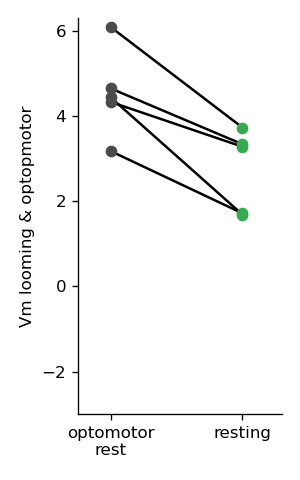

ShapiroResult(statistic=0.8968878984451294, pvalue=0.39292487502098083)
Ttest_relResult(statistic=5.473243666602155, pvalue=0.005422679311162783)
WilcoxonResult(statistic=0.0, pvalue=0.0625)


In [56]:
# plot for NP/HP spont group

# HP group
opmotRest = opmotRest_hyp
combiRest = combiRest_hyp
# NP group
# opmotRest = opmotRest_nop
# combiRest = combiRest_nop


# plot
f,ax=plt.subplots(figsize=(2.5,4))

#plotting markers and lines separate for easier handling of details later
ax.plot(np.vstack((np.zeros_like(opmotRest), np.ones_like(combiRest))), 
        np.vstack((opmotRest, combiRest)),
           #'-', color=plt.cm.Greens(0.9), alpha=0.4)
        '-',color='k', zorder=0)

ax.scatter(np.zeros_like(opmotRest), opmotRest, marker='o', color=np.array([75,75,75])/255)
ax.scatter(np.ones_like(combiRest), combiRest, marker='o', color=(54/255, 170/255, 80/255))

ax.set_xlim([-0.25,1.3])
ax.set_xticks([0,1])
ax.set_xticklabels(['optomotor\nrest','resting'])

ax.set_ylabel('Vm looming & optopmotor')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_yticks([-0.4, 0, 0.4, 1, 1.5])
# ax.set_yticks([-1, 0, 1, 2,3])
ax.set_ylim([-3, 6.3])
plt.tight_layout()

print(stats.shapiro(np.array(opmotRest)-np.array(combiRest)))
print(stats.ttest_rel(opmotRest, combiRest))
# print(stats.wilcoxon(opmotRest, combiRest)) #data is normal -> t-test

In [57]:
# plot for NP/HP group , optomotor and saccades

#for HP group
opmotFly = opmotFly_hyp
combiSacc = combiSacc_hyp
#for NPgroup
# opmotFly = opmotFly_nop
# combiSacc = combiSacc_nop


#plot
f,ax=plt.subplots(figsize=(2.5,4))

#plotting markers and lines separate for easier handling of details later
ax.plot(np.vstack((np.zeros_like(opmotFly), np.ones_like(combiSacc))), 
        np.vstack((opmotFly, combiSacc)),
           #'-', color=plt.cm.Greens(0.9), alpha=0.4)
        '-',color='k', zorder=0)

ax.scatter(np.zeros_like(opmotFly), opmotFly, marker='o', color=np.array([75,75,75])/255)
ax.scatter(np.ones_like(combiSacc), combiSacc, marker='o', color=(200/255, 74/255, 0/255))

ax.set_xlim([-0.25,1.3])
ax.set_xticks([0,1])
ax.set_xticklabels(['optomotor\nflight','saccades'])

ax.set_ylabel('Vm looming & optomotor')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_yticks([-0.4, 0, 0.4, 1, 1.5])
# ax.set_yticks([-1, 0, 1, 2,3])
ax.set_ylim([-3, 6.3])
plt.tight_layout()

print(stats.shapiro(np.array(opmotFly)-np.array(combiSacc)))
print(stats.ttest_rel(opmotFly, combiSacc))
# print(stats.wilcoxon(opmotFly, combiSacc)) #data is normal -> t-test

<IPython.core.display.Javascript object>

ShapiroResult(statistic=0.8546018004417419, pvalue=0.2095072716474533)
Ttest_relResult(statistic=2.7672846357826386, pvalue=0.050471219815230936)
WilcoxonResult(statistic=0.0, pvalue=0.0625)


<IPython.core.display.Javascript object>


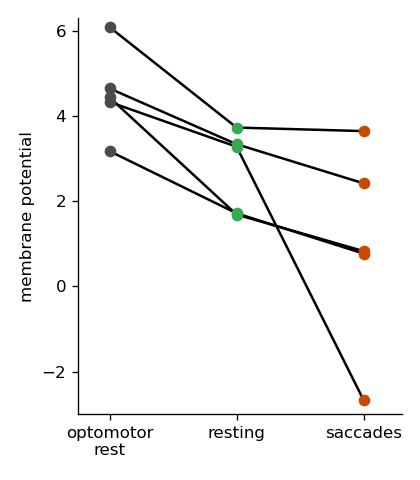

In [71]:
#plot for HPspont group 

f,ax=plt.subplots(figsize=(3.5,4))

#plotting markers and lines separate for easier handling of details later
ax.plot(np.vstack((np.zeros_like(opmotRest_hyp), np.ones_like(combiRest_hyp), np.full_like(combiSacc_hyp, 2))), 
        np.vstack((opmotRest_hyp, combiRest_hyp, combiSacc_hyp)),
           #'-', color=plt.cm.Greens(0.9), alpha=0.4)
        '-',color='k', zorder=0)

ax.scatter(np.zeros_like(opmotRest_hyp), opmotRest_hyp, marker='o', color=np.array([75,75,75])/255)
ax.scatter(np.ones_like(combiRest_hyp), combiRest_hyp, marker='o', color=(54/255, 170/255, 80/255))
ax.scatter(np.full_like(combiSacc_hyp,2), combiSacc_hyp, marker='o', color=(200/255, 74/255, 0/255))

ax.set_xlim([-0.25,2.3])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['optomotor\nrest','resting','saccades'])

ax.set_ylabel('membrane potential')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([-3, 6.3])
plt.tight_layout()

#### more complex HP&NP in one plot
This plot follows the color scheme from Fig 4, where pink and green represent HP and NP group resp.

<IPython.core.display.Javascript object>


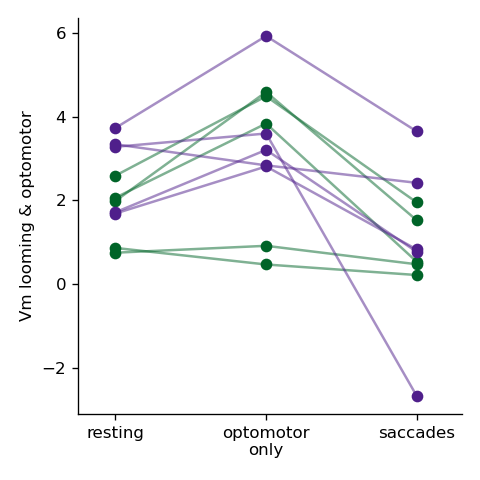

In [72]:
f,ax=plt.subplots(figsize=(4,4))

ax.plot(np.vstack((np.zeros_like(combiRest_nop),np.ones_like(opmotFly_nop), np.full_like(combiSacc_nop,2.))), 
        np.vstack((combiRest_nop, opmotFly_nop, combiSacc_nop)),
           '-', color=plt.cm.Greens(0.9), alpha=0.5)
#plotting markers and lines separate for easier handling of details later
ax.scatter(np.vstack((np.zeros_like(combiRest_nop),np.ones_like(opmotFly_nop), np.full_like(combiSacc_nop,2.))), 
           np.vstack((combiRest_nop, opmotFly_nop, combiSacc_nop)),
           color=plt.cm.Greens(0.9))

ax.plot(np.vstack((np.zeros_like(combiRest_hyp),np.ones_like(opmotFly_hyp),np.full_like(combiSacc_hyp,2.))), 
        np.vstack((combiRest_hyp, opmotFly_hyp, combiSacc_hyp)),
           '-', color=plt.cm.Purples(0.9), alpha=0.5)
#plotting markers and lines separate for easier handling of details later
ax.scatter(np.vstack((np.zeros_like(combiRest_hyp), np.ones_like(opmotFly_hyp), np.full_like(combiSacc_hyp,2.))), 
           np.vstack((combiRest_hyp, opmotFly_hyp, combiSacc_hyp)),
           color=plt.cm.Purples(0.9))

ax.set_xlim([-0.25,2.3])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['resting', 'optomotor\nonly', 'saccades'])

ax.set_ylabel('Vm looming & optomotor')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

In [74]:
f,ax=plt.subplots(figsize=(4,4))

ax.plot(np.vstack((np.zeros_like(combiRest_nop),np.ones_like(opmotRest_nop), np.full_like(opmotFly_nop,2.), np.full_like(combiSacc_nop,3.))), 
        np.vstack((combiRest_nop,opmotRest_nop, opmotFly_nop, combiSacc_nop)),
           '-', color=plt.cm.Greens(0.9), alpha=0.4)
#plotting markers and lines separate for easier handling of details later
ax.scatter(np.vstack((np.zeros_like(combiRest_nop), np.ones_like(opmotRest_nop), np.full_like(opmotFly_nop,2.), np.full_like(combiSacc_nop,3.))), 
           np.vstack((combiRest_nop, opmotRest_nop, opmotFly_nop, combiSacc_nop)),
           color=plt.cm.Greens(0.9))

ax.plot(np.vstack((np.zeros_like(combiRest_hyp),np.ones_like(opmotRest_hyp), np.full_like(opmotFly_hyp,2) ,np.full_like(combiSacc_hyp,3.))), 
        np.vstack((combiRest_hyp, opmotRest_hyp, opmotFly_hyp, combiSacc_hyp)),
           '-', color=plt.cm.Purples(0.9), alpha=0.4)
#plotting markers and lines separate for easier handling of details later
ax.scatter(np.vstack((np.zeros_like(combiRest_hyp), np.ones_like(opmotRest_hyp),np.full_like(opmotFly_hyp,2.), np.full_like(combiSacc_hyp,3.))), 
           np.vstack((combiRest_hyp, opmotRest_hyp, opmotFly_hyp, combiSacc_hyp)),
           color=plt.cm.Purples(0.9))

ax.set_xlim([-0.25,3.3])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['resting', 'optomotor\nrest', 'optomotor\nflight', 'saccades'])

ax.set_ylabel('Vm looming & optomotor')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

<IPython.core.display.Javascript object>

## statistical test on absolute value

Fig 5C optomotor resting (gray) <->< combined resting (green) => paired t-test for both HP and NP
HPspont combi rest (green) <-> combi sacc (red) => Wilcoxon

Fig 5F NPcontra Wilcoxon, HPcontra t-test with Shapiro

NB: Wilcoxon test computes the differences \$d_i = x_i - y_i \$.
The two-sided test has the null hypothesis that the median of the differences is zero against the alternative that it is different from zero. The one-sided test has the null hypothesis that the median is positive (i.e. \$y<x\$ as \$H_0\$) against the alternative that it is negative (alternative == 'less'), or vice versa (alternative == 'greater.', i.e. \$y>x\$).

Thus, if we expect y to be larger than x, set alternative == 'less')  [calling wilcoxon(x,y,...)]

Same logic applies to T-tests.

### NP/HPspont
First we will run tests for the NP/HPspont groups, which means on looming R stimulus

In [123]:
#HP/NPspont
hypolFlies = [v.lower() for _,v in saSacc_Lhyp.flyID.items() if v.lower()!='fly1_x20a_20200316_cell1' ] #HP group, not enough trials in this fly for stim 3
nopolFlies = [v.lower() for _,v in saSacc_Lnop.flyID.items()] #NP group

In [124]:
combi_stimID = 3
opmot_stimID = 6
saSacc_Lhyp.get_stimulusmap(combi_stimID), saSacc_Lhyp.get_stimulusmap(opmot_stimID)

('loom right rot. clw', 'no loom rot. clw')

In [125]:
print(f'combi_stimID={combi_stimID} , omot_stimID={opmot_stimID}')

combi_stimID=3 , omot_stimID=6


In [126]:
combiRest_hyp = [restingSlopeDict[fid][combi_stimID][0]  for fid in hypolFlies]
combiSacc_hyp =  [saccadeSlopeDict[fid][combi_stimID][0]  for fid in hypolFlies]

combiRest_nop = [restingSlopeDict[fid][combi_stimID][0]  for fid in nopolFlies]
combiSacc_nop =  [saccadeSlopeDict[fid][combi_stimID][0]  for fid in nopolFlies]

opmotFly_hyp = [flyingSlopeDict[fid][opmot_stimID][0]  for fid in hypolFlies]
opmotFly_nop = [flyingSlopeDict[fid][opmot_stimID][0]  for fid in nopolFlies]
opmotRest_hyp = [restingSlopeDict[fid][opmot_stimID][0]  for fid in hypolFlies]
opmotRest_nop = [restingSlopeDict[fid][opmot_stimID][0]  for fid in nopolFlies]

In [127]:
# are the pop. (distr of response) signif. diff. combined resting vs optomotor only
# (in other words, grey vs gren in plots above)

print('test rest combi vs omot only (within groups)')
print(f'HP group normality test: {stats.shapiro(np.array(combiRest_hyp)-np.array(opmotRest_hyp))},\n'
      f'NP group normality test: {stats.shapiro(np.array(combiRest_nop)-np.array(opmotRest_nop))}')

print(f"HP group: {stats.ttest_rel(combiRest_hyp, opmotRest_hyp, alternative='less')},\n"
     f"NP groups: {stats.ttest_rel(combiRest_nop, opmotRest_nop, alternative='less')}")

test rest combi vs omot only (within groups)
HP group normality test: ShapiroResult(statistic=0.896888017654419, pvalue=0.392925500869751),
NP group normality test: ShapiroResult(statistic=0.8762285113334656, pvalue=0.29256850481033325)
HP group: Ttest_relResult(statistic=-5.473243666602155, pvalue=0.0027113396555813914),
NP groups: Ttest_relResult(statistic=-2.101816603901617, pvalue=0.05172048360185302)


In [128]:
# are the pop. (distr of response) signif. diff. combined saccades vs optomotor only
print('test rest combi vs omot only (within groups)')
print(f'HP group normality test: {stats.shapiro(np.array(combiSacc_hyp)-np.array(opmotRest_hyp))}')
print(f"HP group: {stats.ttest_rel(combiSacc_hyp, opmotRest_hyp, alternative='less')}") #for CLW rot.
print("not normal distributed, therefore Wilcoxon")
print(f"HP group: {stats.wilcoxon(combiSacc_hyp, opmotRest_hyp, alternative='less', mode='exact')}") #for CLW rot.
# print(f"HP group: {stats.ttest_rel(combiSacc_hyp, opmotRest_hyp, alternative='two-sided')},\n" #for CCK rot.
#      f"NP group: {stats.ttest_rel(combiSacc_nop, opmotRest_nop, alternative='two-sided')}")

test rest combi vs omot only (within groups)
HP group normality test: ShapiroResult(statistic=0.7400357723236084, pvalue=0.02400333061814308)
HP group: Ttest_relResult(statistic=-3.929371079610029, pvalue=0.008556033332201098)
not normal distributed, therefore Wilcoxon
HP group: WilcoxonResult(statistic=0.0, pvalue=0.03125)


In [129]:
# are the pop. (distr of response) signif. diff. combined saccades vs optomotor only
# red vs green
print('test rest combi vs omot only (within groups)')
print(f'HP group normality test: {stats.shapiro(np.array(combiSacc_hyp)-np.array(combiRest_hyp))}')
print(f"HP group: {stats.ttest_rel(combiSacc_hyp, combiRest_hyp, alternative='less')}") #for CLW rot.
print("not normal distributed, therefore Wilcoxon")
print(f"HP group: {stats.wilcoxon(combiSacc_hyp, combiRest_hyp, alternative='less', mode='exact')}") #for CLW rot.
# print(f"HP group: {stats.ttest_rel(combiSacc_hyp, opmotRest_hyp, alternative='two-sided')},\n" #for CCK rot.
#      f"NP group: {stats.ttest_rel(combiSacc_nop, opmotRest_nop, alternative='two-sided')}")

test rest combi vs omot only (within groups)
HP group normality test: ShapiroResult(statistic=0.6815470457077026, pvalue=0.006079163867980242)
HP group: Ttest_relResult(statistic=-1.6493033439537919, pvalue=0.08721527263336022)
not normal distributed, therefore Wilcoxon
HP group: WilcoxonResult(statistic=0.0, pvalue=0.03125)


In [130]:
# specifically for IPSILATERAL LOOMING , all flies combined

print(stats.shapiro(np.array([*combiRest_hyp, *combiRest_nop]) - np.array([*opmotRest_hyp,*opmotRest_nop])))
stats.ttest_rel([*combiRest_hyp, *combiRest_nop], [*opmotRest_hyp,*opmotRest_nop]),\

# stats.wilcoxon([*combiRest_hyp, *combiRest_nop], [*opmotRest_hyp,*opmotRest_nop], mode='exact')

ShapiroResult(statistic=0.9440183639526367, pvalue=0.5985285043716431)


(Ttest_relResult(statistic=-4.46366152999181, pvalue=0.0015689438169307608),)

### NP/HPcontra
Next we will run tests for the NP/HPcontra groups, which means on looming L stimulus

In [109]:
# HP/NPcontra
hypolFlies = [v.lower() for _,v in saSacc_Rhyp.flyID.items()]
nopolFlies = [v.lower() for _,v in saSacc_Rnop.flyID.items()]

In [110]:
combi_stimID = 0
opmot_stimID = 6
saSacc_Lhyp.get_stimulusmap(combi_stimID), saSacc_Lhyp.get_stimulusmap(opmot_stimID)

('loom left rot. clw', 'no loom rot. clw')

In [111]:
print(f'combi_stimID={combi_stimID} , omot_stimID={opmot_stimID}')

combi_stimID=0 , omot_stimID=6


In [112]:
combiRest_hyp = [restingSlopeDict[fid][combi_stimID][0]  for fid in hypolFlies]
combiSacc_hyp =  [saccadeSlopeDict[fid][combi_stimID][0]  for fid in hypolFlies]

combiRest_nop = [restingSlopeDict[fid][combi_stimID][0]  for fid in nopolFlies]
combiSacc_nop =  [saccadeSlopeDict[fid][combi_stimID][0]  for fid in nopolFlies]

opmotFly_hyp = [flyingSlopeDict[fid][opmot_stimID][0]  for fid in hypolFlies]
opmotFly_nop = [flyingSlopeDict[fid][opmot_stimID][0]  for fid in nopolFlies]
opmotRest_hyp = [restingSlopeDict[fid][opmot_stimID][0]  for fid in hypolFlies]
opmotRest_nop = [restingSlopeDict[fid][opmot_stimID][0]  for fid in nopolFlies]

In [120]:
# are the pop. (distr of response) signif. diff. combined saccade vs optomotor only (in flight)
# (in other words, grey vs red in plots above)

print('test rest combi vs omot only (within groups)')
print(f'HP group normality test: {stats.shapiro(np.array(combiSacc_hyp)-np.array(opmotFly_hyp))},\n'
      f'NP group normality test: {stats.shapiro(np.array(combiSacc_nop)-np.array(opmotFly_nop))}')
print()
print(f"HP group: {stats.ttest_rel(combiSacc_hyp, opmotFly_hyp, alternative='less')},\n"
     f"NP groups: {stats.ttest_rel(combiSacc_nop, opmotFly_nop, alternative='less')}")
print()
print('Wilcoxon where needed')
print(f"NP groups: {stats.wilcoxon(combiSacc_nop, opmotFly_nop, alternative='less', mode='exact')}")

test rest combi vs omot only (within groups)
HP group normality test: ShapiroResult(statistic=0.9962811470031738, pvalue=0.9869317412376404),
NP group normality test: ShapiroResult(statistic=0.7967464327812195, pvalue=0.01874570921063423)

HP group: Ttest_relResult(statistic=-6.228320397801982, pvalue=0.004172765259130573),
NP groups: Ttest_relResult(statistic=2.3269160560325095, pvalue=0.9758029443248973)

Wilcoxon where needed
NP groups: WilcoxonResult(statistic=41.0, pvalue=0.990234375)
